# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [31]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [33]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.441292
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*
- Because there's 10 classes, by initialize with random weights, each class should has same possibility 1/10.

In [34]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.927047 analytic: -1.927047, relative error: 5.740587e-08
numerical: -1.795655 analytic: -1.795655, relative error: 2.062075e-08
numerical: -1.250615 analytic: -1.250614, relative error: 4.010706e-08
numerical: 5.991641 analytic: 5.991640, relative error: 6.732212e-09
numerical: -2.133731 analytic: -2.133731, relative error: 2.961581e-09
numerical: -1.836689 analytic: -1.836689, relative error: 1.586974e-08
numerical: 0.738910 analytic: 0.738910, relative error: 5.923412e-08
numerical: 0.120966 analytic: 0.120966, relative error: 2.269411e-07
numerical: -0.815862 analytic: -0.815862, relative error: 7.332057e-09
numerical: 5.832936 analytic: 5.832936, relative error: 8.475831e-09
numerical: -0.254732 analytic: -0.254732, relative error: 6.466996e-08
numerical: -0.308471 analytic: -0.308470, relative error: 2.112811e-07
numerical: 0.010004 analytic: 0.010003, relative error: 6.511927e-06
numerical: -1.932408 analytic: -1.932408, relative error: 1.394059e-08
numerical: -1.35

In [35]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.441292e+00 computed in 0.099584s
vectorized loss: 2.441292e+00 computed in 0.022390s
Loss difference: 0.000000
Gradient difference: 0.000000


In [37]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 4e-7, 8e-7, 1e-6, 4e-6, 8e-6, 1e-5, 5e-5]
regularization_strengths = [0.5e4, 1e4, 
                            1.1e4, 1.2e4, 1.3e4, 1.4e4, 1.5e4, 1.6e4, 1.7e4, 1.8e4, 1.9e4, 
                            2e4, 2.1e4, 2.2e4, 2.3e4, 2.4e4, 2.5e4, 
                            3e4, 4e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        print('learning_rate: %.10f' % lr)
        print('regularization_strengths: %.10f' % reg)
        softmax = Softmax() # Always create a new Softmax Object
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000, verbose=True)
        
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: %.10f' % (np.mean(y_train == y_train_pred), ))
                             
        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)               
        print('validation accuracy: %.10f' % (np.mean(y_val == y_val_pred), ))
        
        results[(lr, reg)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax
        print("------------------------------")
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning_rate: 0.0000001000
regularization_strengths: 5000.0000000000
iteration 0 / 1000: loss 82.449130
iteration 100 / 1000: loss 73.449809
iteration 200 / 1000: loss 65.974751
iteration 300 / 1000: loss 59.899125
iteration 400 / 1000: loss 53.692640
iteration 500 / 1000: loss 48.738909
iteration 600 / 1000: loss 44.295614
iteration 700 / 1000: loss 40.053068
iteration 800 / 1000: loss 36.331790
iteration 900 / 1000: loss 32.918686
training accuracy: 0.2604693878
validation accuracy: 0.2490000000
------------------------------
learning_rate: 0.0000001000
regularization_strengths: 10000.0000000000
iteration 0 / 1000: loss 157.907056
iteration 100 / 1000: loss 128.967961
iteration 200 / 1000: loss 105.239197
iteration 300 / 1000: loss 86.240169
iteration 400 / 1000: loss 70.527177
iteration 500 / 1000: loss 58.171681
iteration 600 / 1000: loss 47.751059
iteration 700 / 1000: loss 39.444172
iteration 800 / 1000: loss 32.655577
iteration 900 / 1000: loss 26.977843
training accuracy: 0.28

iteration 200 / 1000: loss 143.108218
iteration 300 / 1000: loss 89.099331
iteration 400 / 1000: loss 55.802364
iteration 500 / 1000: loss 35.212818
iteration 600 / 1000: loss 22.475077
iteration 700 / 1000: loss 14.575882
iteration 800 / 1000: loss 9.794400
iteration 900 / 1000: loss 6.872403
training accuracy: 0.3345306122
validation accuracy: 0.3500000000
------------------------------
learning_rate: 0.0000001000
regularization_strengths: 25000.0000000000
iteration 0 / 1000: loss 392.514781
iteration 100 / 1000: loss 237.265639
iteration 200 / 1000: loss 143.967456
iteration 300 / 1000: loss 87.875513
iteration 400 / 1000: loss 53.877667
iteration 500 / 1000: loss 33.396550
iteration 600 / 1000: loss 20.973979
iteration 700 / 1000: loss 13.583436
iteration 800 / 1000: loss 8.943383
iteration 900 / 1000: loss 6.164228
training accuracy: 0.3341632653
validation accuracy: 0.3550000000
------------------------------
learning_rate: 0.0000001000
regularization_strengths: 30000.0000000000


iteration 800 / 1000: loss 2.012745
iteration 900 / 1000: loss 1.991005
training accuracy: 0.3614489796
validation accuracy: 0.3710000000
------------------------------
learning_rate: 0.0000004000
regularization_strengths: 21000.0000000000
iteration 0 / 1000: loss 326.512635
iteration 100 / 1000: loss 61.107445
iteration 200 / 1000: loss 12.864948
iteration 300 / 1000: loss 4.068283
iteration 400 / 1000: loss 2.376390
iteration 500 / 1000: loss 2.118594
iteration 600 / 1000: loss 2.019231
iteration 700 / 1000: loss 2.039924
iteration 800 / 1000: loss 2.075713
iteration 900 / 1000: loss 2.062933
training accuracy: 0.3582857143
validation accuracy: 0.3720000000
------------------------------
learning_rate: 0.0000004000
regularization_strengths: 22000.0000000000
iteration 0 / 1000: loss 344.280981
iteration 100 / 1000: loss 59.547948
iteration 200 / 1000: loss 11.805648
iteration 300 / 1000: loss 3.679468
iteration 400 / 1000: loss 2.324205
iteration 500 / 1000: loss 2.076608
iteration 60

iteration 100 / 1000: loss 18.676038
iteration 200 / 1000: loss 3.044115
iteration 300 / 1000: loss 2.008794
iteration 400 / 1000: loss 1.963477
iteration 500 / 1000: loss 2.017678
iteration 600 / 1000: loss 1.937459
iteration 700 / 1000: loss 1.994301
iteration 800 / 1000: loss 2.030584
iteration 900 / 1000: loss 1.965702
training accuracy: 0.3564897959
validation accuracy: 0.3690000000
------------------------------
learning_rate: 0.0000008000
regularization_strengths: 18000.0000000000
iteration 0 / 1000: loss 278.866807
iteration 100 / 1000: loss 16.922535
iteration 200 / 1000: loss 2.794835
iteration 300 / 1000: loss 2.074791
iteration 400 / 1000: loss 2.036254
iteration 500 / 1000: loss 2.059248
iteration 600 / 1000: loss 1.971209
iteration 700 / 1000: loss 2.036307
iteration 800 / 1000: loss 1.989056
iteration 900 / 1000: loss 2.020224
training accuracy: 0.3547959184
validation accuracy: 0.3770000000
------------------------------
learning_rate: 0.0000008000
regularization_streng

iteration 900 / 1000: loss 1.887528
training accuracy: 0.3630612245
validation accuracy: 0.3660000000
------------------------------
learning_rate: 0.0000010000
regularization_strengths: 14000.0000000000
iteration 0 / 1000: loss 219.131322
iteration 100 / 1000: loss 14.633562
iteration 200 / 1000: loss 2.695043
iteration 300 / 1000: loss 2.008912
iteration 400 / 1000: loss 1.952753
iteration 500 / 1000: loss 1.923506
iteration 600 / 1000: loss 1.988773
iteration 700 / 1000: loss 1.965156
iteration 800 / 1000: loss 2.081666
iteration 900 / 1000: loss 1.909304
training accuracy: 0.3621428571
validation accuracy: 0.3670000000
------------------------------
learning_rate: 0.0000010000
regularization_strengths: 15000.0000000000
iteration 0 / 1000: loss 235.174874
iteration 100 / 1000: loss 13.102829
iteration 200 / 1000: loss 2.526821
iteration 300 / 1000: loss 1.929189
iteration 400 / 1000: loss 1.972240
iteration 500 / 1000: loss 1.945894
iteration 600 / 1000: loss 1.939675
iteration 700 

iteration 200 / 1000: loss 2.151513
iteration 300 / 1000: loss 2.012125
iteration 400 / 1000: loss 2.146123
iteration 500 / 1000: loss 2.130010
iteration 600 / 1000: loss 2.053469
iteration 700 / 1000: loss 1.962029
iteration 800 / 1000: loss 2.062614
iteration 900 / 1000: loss 2.046752
training accuracy: 0.3288163265
validation accuracy: 0.3310000000
------------------------------
learning_rate: 0.0000040000
regularization_strengths: 11000.0000000000
iteration 0 / 1000: loss 176.177257
iteration 100 / 1000: loss 2.057204
iteration 200 / 1000: loss 1.955396
iteration 300 / 1000: loss 2.088225
iteration 400 / 1000: loss 1.938602
iteration 500 / 1000: loss 2.026935
iteration 600 / 1000: loss 2.074141
iteration 700 / 1000: loss 1.968177
iteration 800 / 1000: loss 2.042615
iteration 900 / 1000: loss 2.012003
training accuracy: 0.3166122449
validation accuracy: 0.3320000000
------------------------------
learning_rate: 0.0000040000
regularization_strengths: 12000.0000000000
iteration 0 / 10

training accuracy: 0.2867142857
validation accuracy: 0.2980000000
------------------------------
learning_rate: 0.0000040000
regularization_strengths: 30000.0000000000
iteration 0 / 1000: loss 471.106592
iteration 100 / 1000: loss 2.108848
iteration 200 / 1000: loss 2.148014
iteration 300 / 1000: loss 2.473048
iteration 400 / 1000: loss 2.192728
iteration 500 / 1000: loss 2.224683
iteration 600 / 1000: loss 2.043044
iteration 700 / 1000: loss 2.266783
iteration 800 / 1000: loss 2.118050
iteration 900 / 1000: loss 2.063160
training accuracy: 0.2751428571
validation accuracy: 0.2800000000
------------------------------
learning_rate: 0.0000040000
regularization_strengths: 40000.0000000000
iteration 0 / 1000: loss 619.776437
iteration 100 / 1000: loss 2.164250
iteration 200 / 1000: loss 2.136319
iteration 300 / 1000: loss 2.173428
iteration 400 / 1000: loss 2.215859
iteration 500 / 1000: loss 2.176737
iteration 600 / 1000: loss 2.400864
iteration 700 / 1000: loss 2.134039
iteration 800 / 

iteration 300 / 1000: loss 3.373423
iteration 400 / 1000: loss 4.005434
iteration 500 / 1000: loss 3.752898
iteration 600 / 1000: loss 4.278333
iteration 700 / 1000: loss 3.577651
iteration 800 / 1000: loss 3.959333
iteration 900 / 1000: loss 3.933633
training accuracy: 0.1760000000
validation accuracy: 0.1940000000
------------------------------
learning_rate: 0.0000080000
regularization_strengths: 23000.0000000000
iteration 0 / 1000: loss 360.425822
iteration 100 / 1000: loss 4.043077
iteration 200 / 1000: loss 4.512067
iteration 300 / 1000: loss 3.730043
iteration 400 / 1000: loss 2.777903
iteration 500 / 1000: loss 3.810502
iteration 600 / 1000: loss 3.878998
iteration 700 / 1000: loss 4.068817
iteration 800 / 1000: loss 2.678442
iteration 900 / 1000: loss 3.081879
training accuracy: 0.2021428571
validation accuracy: 0.2170000000
------------------------------
learning_rate: 0.0000080000
regularization_strengths: 24000.0000000000
iteration 0 / 1000: loss 374.963380
iteration 100 / 

iteration 100 / 1000: loss 4.948472
iteration 200 / 1000: loss 3.790286
iteration 300 / 1000: loss 5.514206
iteration 400 / 1000: loss 5.769794
iteration 500 / 1000: loss 6.327070
iteration 600 / 1000: loss 4.952430
iteration 700 / 1000: loss 3.888341
iteration 800 / 1000: loss 5.556946
iteration 900 / 1000: loss 5.842220
training accuracy: 0.1657346939
validation accuracy: 0.1810000000
------------------------------
learning_rate: 0.0000100000
regularization_strengths: 20000.0000000000
iteration 0 / 1000: loss 310.493573
iteration 100 / 1000: loss 6.115711
iteration 200 / 1000: loss 5.374214
iteration 300 / 1000: loss 4.543652
iteration 400 / 1000: loss 4.291266
iteration 500 / 1000: loss 5.950699
iteration 600 / 1000: loss 4.819503
iteration 700 / 1000: loss 4.406888
iteration 800 / 1000: loss 5.023982
iteration 900 / 1000: loss 5.741937
training accuracy: 0.2008163265
validation accuracy: 0.2020000000
------------------------------
learning_rate: 0.0000100000
regularization_strength

iteration 700 / 1000: loss 56.864612
iteration 800 / 1000: loss 59.815258
iteration 900 / 1000: loss 59.281944
training accuracy: 0.1067346939
validation accuracy: 0.0940000000
------------------------------
learning_rate: 0.0000500000
regularization_strengths: 16000.0000000000
iteration 0 / 1000: loss 250.613451
iteration 100 / 1000: loss 54.143263
iteration 200 / 1000: loss 66.171374
iteration 300 / 1000: loss 65.906391
iteration 400 / 1000: loss 51.004969
iteration 500 / 1000: loss 71.209090
iteration 600 / 1000: loss 67.282104
iteration 700 / 1000: loss 61.918034
iteration 800 / 1000: loss 68.691753
iteration 900 / 1000: loss 71.183473
training accuracy: 0.1071632653
validation accuracy: 0.0960000000
------------------------------
learning_rate: 0.0000500000
regularization_strengths: 17000.0000000000
iteration 0 / 1000: loss 269.113310
iteration 100 / 1000: loss 66.614471
iteration 200 / 1000: loss 71.405825
iteration 300 / 1000: loss 76.969744
iteration 400 / 1000: loss 61.080281


/home/yxue/stanford-cs231n-spring1718/assignment1/cs231n/classifiers/softmax.py:78: RuntimeWarning: divide by zero encountered in log
  cross_entropy_loss = -np.log(softmax[np.arange(softmax.shape[0]), y])


iteration 100 / 1000: loss 285.464823
iteration 200 / 1000: loss 287.037028
iteration 300 / 1000: loss 330.751269
iteration 400 / 1000: loss 300.786665
iteration 500 / 1000: loss 311.840666
iteration 600 / 1000: loss 264.018426
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss 276.452952
iteration 900 / 1000: loss 285.238838
training accuracy: 0.0653877551
validation accuracy: 0.0680000000
------------------------------
learning_rate: 0.0000500000
regularization_strengths: 40000.0000000000
iteration 0 / 1000: loss 620.393752


/home/yxue/stanford-cs231n-spring1718/assignment1/cs231n/classifiers/softmax.py:77: RuntimeWarning: overflow encountered in exp
  softmax = np.exp(X.dot(W)) / np.sum(np.exp(X.dot(W)), axis=1, keepdims=True)
/home/yxue/stanford-cs231n-spring1718/assignment1/cs231n/classifiers/softmax.py:77: RuntimeWarning: invalid value encountered in true_divide
  softmax = np.exp(X.dot(W)) / np.sum(np.exp(X.dot(W)), axis=1, keepdims=True)


iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
training accuracy: 0.1002653061
validation accuracy: 0.0870000000
------------------------------
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.260469 val accuracy: 0.249000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.286653 val accuracy: 0.287000
lr 1.000000e-07 reg 1.100000e+04 train accuracy: 0.297122 val accuracy: 0.299000
lr 1.000000e-07 reg 1.200000e+04 train accuracy: 0.297449 val accuracy: 0.291000
lr 1.000000e-07 reg 1.300000e+04 train accuracy: 0.306633 val accuracy: 0.315000
lr 1.000000e-07 reg 1.400000e+04 train accuracy: 0.307102 val accuracy: 0.303000
lr 1.000000e-07 reg 1.500000e+04 train accuracy: 0.314245 val accuracy: 0.326000
lr 1.000000e-07 reg 1.600000e+04 train accuracy: 0.321347

In [38]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.373000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:
- True

*Your explanation*:
- if the new datapoint's score is out of the margin range from the correct class score the SVM loss wouldn't change, but in the Softmax loss if the score of the new added datapoint be close to positive infinity it will make the softmax value of correct class very small which makes the loss extremly huge, so definitely affect the loss

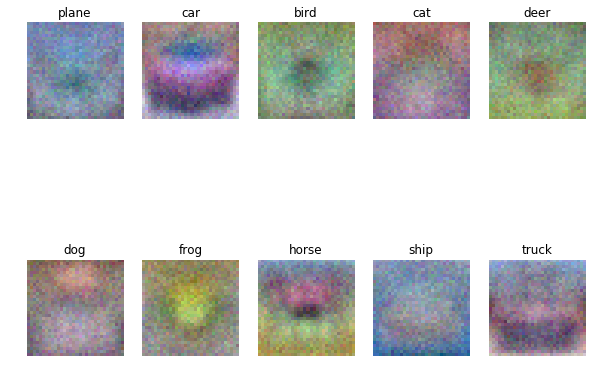

In [39]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])